In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Download stock data for Leejam Sports Company (1830.SR)
leejam_stock = yf.download('1830.SR', start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


In [3]:
leejam_stock.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,1830.SR,1830.SR,1830.SR,1830.SR,1830.SR,1830.SR
Date,,,,,,
2018-09-10,44.459999,51.000000,54.500000,50.200001,54.000000,1918555
2018-09-11,43.588234,50.000000,53.500000,49.900002,50.700001,931497
2018-09-12,43.588234,50.000000,52.099998,49.700001,50.500000,652157
2018-09-13,44.198467,50.700001,51.400002,50.000000,50.200001,384111
2018-09-16,43.588234,50.000000,51.099998,49.000000,50.900002,286693


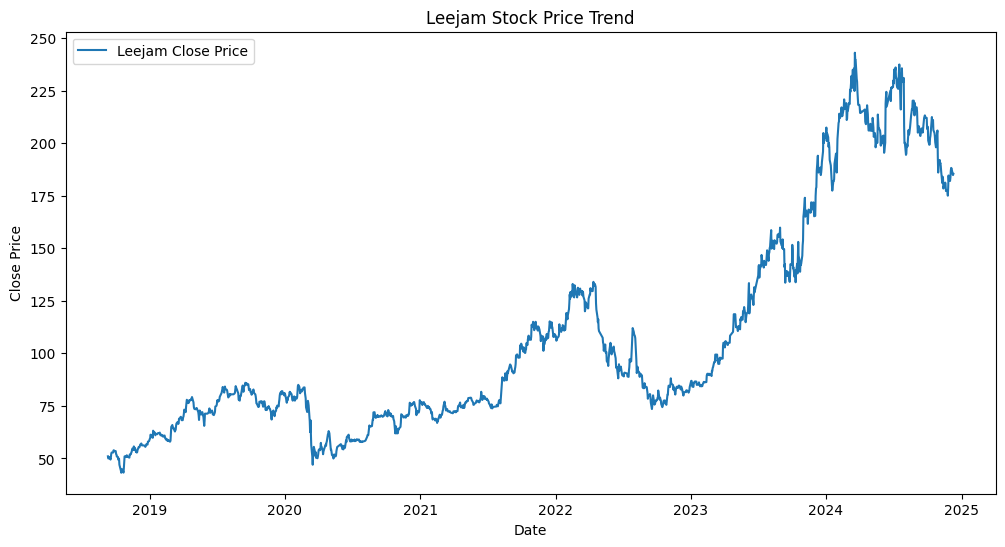

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(leejam_stock['Close'], label='Leejam Close Price')
plt.title('Leejam Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [5]:
# Set Date as index if not already
if 'Date' not in leejam_stock.columns:
    leejam_stock['Date'] = leejam_stock.index
leejam_stock.set_index('Date', inplace=True)

leejam_prices = leejam_stock['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
leejam_prices_scaled = scaler.fit_transform(leejam_prices)
joblib.dump(scaler, "leejam_scaler.joblib")  # Save the fitted scaler

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(leejam_prices_scaled) * 0.8)
train_data = leejam_prices_scaled[:train_size]
test_data = leejam_prices_scaled[train_size:]

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Early stopping to prevent overfitting and stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.keras',  # Filepath to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only when the model is the best
    verbose=1                      # Print saving info
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor validation loss
    factor=0.5,                    # Reduce learning rate by a factor of 0.5
    patience=5,                    # Number of epochs with no improvement before reducing
    min_lr=1e-6,                   # Minimum learning rate
    verbose=1                      # Print learning rate reduction info
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [8]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks  # Include callbacks in training
)


Epoch 1/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077
Epoch 1: val_loss improved from inf to 0.00242, saving model to best_lstm_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0077 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.5616e-04
Epoch 2: val_loss did not improve from 0.00242
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.5595e-04 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3984e-04
Epoch 3: val_loss improved from 0.00242 to 0.00160, saving model to best_lstm_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 4.3970e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.0226e-04
Epoch 4: val_loss improved from 0.00160 to 0.00154, saving model to best_lstm_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.0152e-04 - val_loss: 0.0015 - learning_rate

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


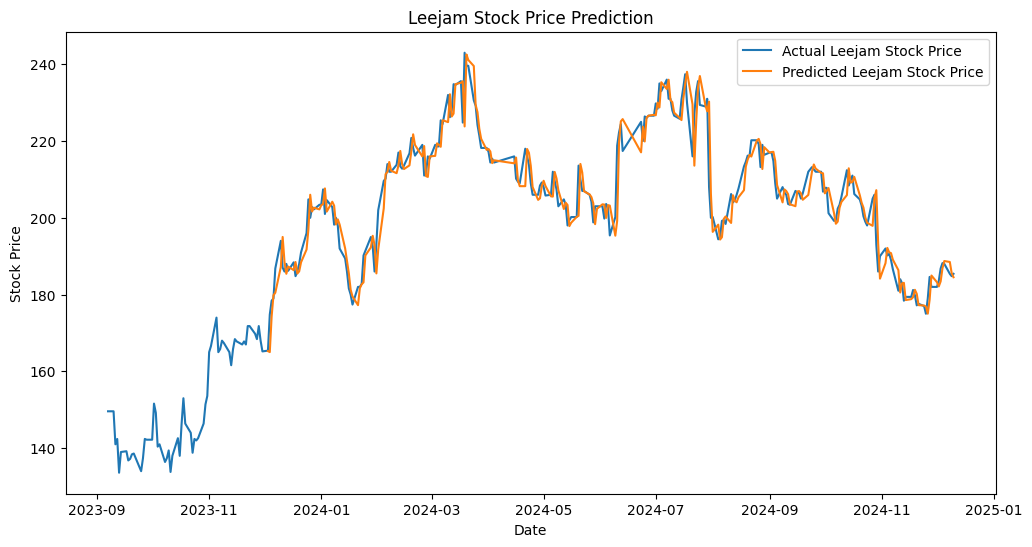

In [9]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(leejam_stock.index[train_size:], leejam_stock['Close'][train_size:], label='Actual Leejam Stock Price')
plt.plot(leejam_stock.index[train_size + seq_length:], predictions, label='Predicted Leejam Stock Price')
plt.title('Leejam Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [10]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test, predictions)

RMSE: 205.95659664419645, MAE: 205.34914171545518, R2: -6862983.805425004


[*********************100%***********************]  1 of 1 completed

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


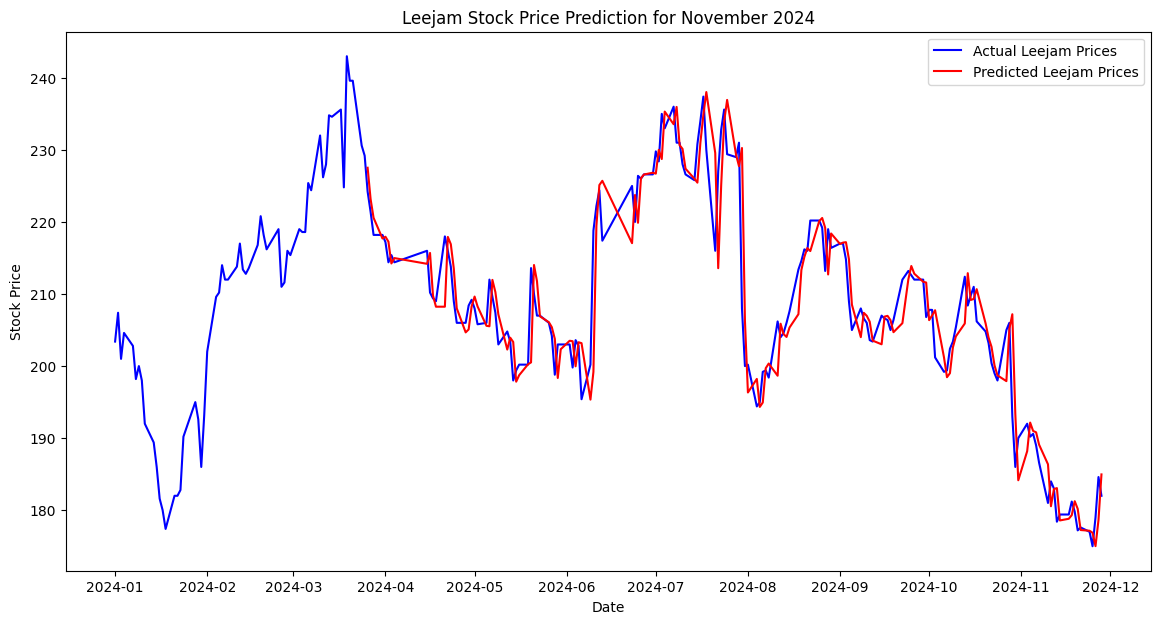

In [11]:
# Fetch data from Yahoo Finance
leejam_stock = yf.download("1830.SR", start="2024-01-01", end="2024-11-30")
leejam_stock['Date'] = leejam_stock.index
leejam_prices = leejam_stock['Close'].values.reshape(-1, 1)

# Scale the data using the same scaler
# scaler = MinMaxScaler()
leejam_prices_scaled = scaler.transform(leejam_prices)

# Create sequences for prediction
seq_length = 60
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_future = create_sequences(leejam_prices_scaled, seq_length)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot real vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(leejam_stock['Date'], leejam_stock['Close'], label="Actual Leejam Prices", color='blue')
plt.plot(leejam_stock['Date'][seq_length:], predictions_rescaled, label="Predicted Leejam Prices", color='red')
plt.title("Leejam Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
